
# K-Nearest Neighbours 
Our goal is to implement a K-NN classifier and apply it to classify the Iris dataset.
We always have this set of imports at the beginning of our notebooks.

In [44]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
np.random.seed(1234)

We conveniently load the dataset from the sklearn collection of datasets, and visualize it using `pandas` package. This package is useful for data-processing; however we don't work with it in the class

In [45]:
from sklearn import datasets
dataset = datasets.load_iris()
#print(dataset.DESCR)

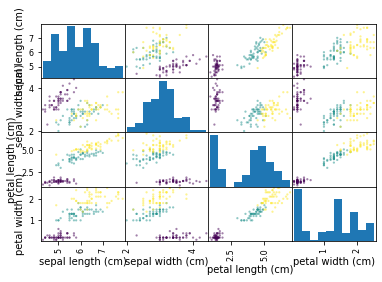

In [46]:
import pandas as pd
from pandas.plotting import scatter_matrix
#creating data frame for pandas
dataframe = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
#ploting scatter graph of species comparing all features to each other
scatter_matrix(dataframe, c=dataset['target'],marker='o', s=5)
#print(dataframe)
plt.show()

create the input matrix $X \in \mathbb{R}^{N \times D}$ and the output vector $y \in \{1,\ldots,C\}^N$
let's only use `sepal length` and `sepal width` for classification, since we know they have high correlation with the class label. We then randomly split the data into train and test and visualize the data.

instances (N) 	 150 
 features (D) 	 2 
 classes (C) 	 3


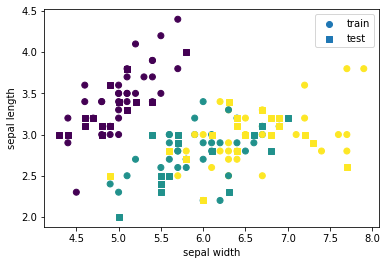

In [47]:
x, y = dataset['data'][:,:2], dataset['target']
(N,D), C = x.shape, np.max(y)+1
print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')
inds = np.random.permutation(N)
#train-test split)
x_train, y_train = x[inds[:100]], y[inds[:100]]
x_test, y_test = x[inds[100:]], y[inds[100:]]
#visualization
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', label='train')
plt.scatter(x_test[:,0], x_test[:,1], c=y_test, marker='s', label='test')
plt.legend()
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.show()

## the `KNN` class
We implement our models as python classes. Two class methods that we usually need to implement are `fit` and `predict`; which respectively perform training by fitting the data, and making prediction on new data. In the `__init__` function, we initialize our model, usually this includes an assignment to *hyper-parameters*.

In [48]:
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)

class KNN:
    
    def __init__(self, K=1, dist_fn= euclidean):
        self.dist_fn = dist_fn
        self.K = K
        return
    
    def fit(self, x,y):
        self.x = x
        self.y = y
        self.C = np.max(y) + 1
        return self
    
    def predict(self, x_test):
        num_test = x_test.shape[0]
        distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:]) # num_test x num_train
        y_prob = np.zeros((x_test.shape[0], self.C))
        knns = np.zeros((x_test.shape[0], self.K), dtype=int)
        for i in range(num_test):
            knns[i,:] = np.argsort(distances[i])[:self.K]
            y_prob[i,:] = np.bincount(self.y[knns[i,:]], minlength=self.C)
        y_prob /= np.sum(y_prob,1,keepdims=True)
        return y_prob, knns

next we `fit` a model, and make a prediction on test set. Then, we also connect each test node to its closest nearest neighbors in the plot.

accuracy is 78.0.


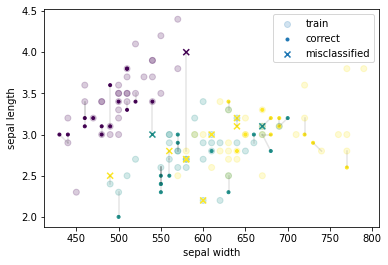

In [50]:
model = KNN(K=1)
y_prob, knns = model.fit(x_train, y_train).predict(x_test)
y_pred = np.argmax(y_prob,1)
accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
print(f'accuracy is {accuracy*100:.1f}.')
#visualization
correct = y_test == y_pred
incorrect = np.logical_not(correct)
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', alpha=.2, label='train')
plt.scatter(x_test[correct,0], x_test[correct,1], marker='.', c=y_pred[correct], label='correct')
plt.scatter(x_test[incorrect,0], x_test[incorrect,1], marker='x', c=y_test[incorrect], label='misclassified')

#connect each node to k-nearest neighbours in the training set
for i in range(x_test.shape[0]):
    for k in range(model.K):
        hor = x_test[i,0], x_train[knns[i,k],0]
        ver = x_test[i,1], x_train[knns[i,k],1]
        plt.plot(hor, ver, 'k-', alpha=.1)
    
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.legend()
plt.show()

# Decision Boundaries
To draw the decision boundary we classify all the points on a 2D grid. `meshgrid` function creates all the points on the grid by taking discritizations of horizontal and vertical axes.

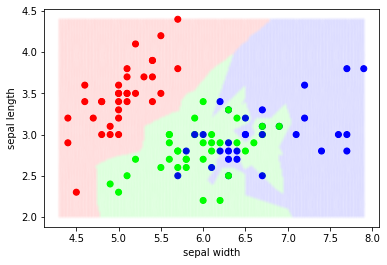

In [20]:
x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)
x0,x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

model = KNN(K=2)
y_train_prob = np.zeros((y_train.shape[0], C))
y_train_prob[np.arange(y_train.shape[0]), y_train] = 1
y_prob_all, _ = model.fit(x_train, y_train).predict(x_all)
y_pred_all = np.zeros_like(y_prob_all)
y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, 1)] = 1
plt.scatter(x_train[:,0], x_train[:,1], c=y_train_prob, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=y_pred_all, marker='.', alpha=.01)
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.show()

We can also plot class probabilities

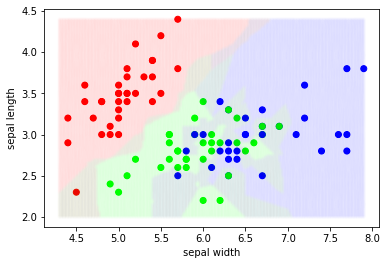

In [21]:
plt.scatter(x_train[:,0], x_train[:,1], c=y_train_prob, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=y_prob_all, marker='.', alpha=.01)
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.show()

## The Effect of Noise and Feature Scaling
Nearest neighbours are highly affected by the existence of noisy or irrelevant features.
Lets add noise and see how it affects the accuracy of our classifier.

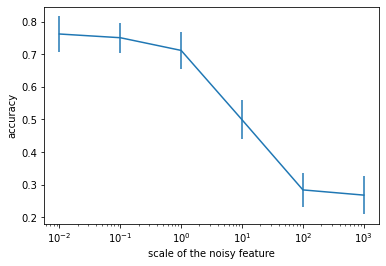

In [23]:
noise_scale = [.01, .1, 1, 10,100, 1000]
noise = np.random.randn(x.shape[0],1)
results = []
for s in noise_scale:
    x_n = np.column_stack((x, noise*s))
    results.append([])
    for r in range(100):
        inds = np.random.permutation(N)
        #train-test split
        x_train, y_train = x_n[inds[:100]], y[inds[:100]]
        x_test, y_test = x_n[inds[100:]], y[inds[100:]]
        model = KNN(K=5)
        y_prob, _ = model.fit(x_train, y_train).predict(x_test)
        y_pred = np.argmax(y_prob,1)
        accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
        results[-1].append(accuracy)
results = np.array(results)
plt.errorbar(noise_scale, results.mean(1), results.std(1))
plt.xscale('log')
plt.xlabel("scale of the noisy feature")
plt.ylabel("accuracy")
plt.show()

as we increase the scale of irrelevant feature it plays a more important role when calculating distances, and so the K nearest neighbors are more decided by the noisy feature rather than the relevant ones.